# Model Evaluation for [retinanet_resnet50_fpn_v2](https://pytorch.org/vision/main/models/generated/torchvision.models.detection.retinanet_resnet50_fpn_v2.html#retinanet-resnet50-fpn-v2)

In [1]:
from my_utils.dataset_loader import ObjectDetectionDataset, DatasetMode, simple_collate_fn
from torch.utils.data import DataLoader
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    average_precision_score, roc_auc_score,
    multilabel_confusion_matrix
)
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from torchvision.models.detection import RetinaNet_ResNet50_FPN_V2_Weights

warnings.filterwarnings("ignore")

In [2]:
data_dir = "D:\\Projects\\ml-ops-wildlife\\data\\WAID"

In [3]:
torch.cuda.is_available()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [11]:
test_dataset = ObjectDetectionDataset(data_dir, DatasetMode.TEST, transform=RetinaNet_ResNet50_FPN_V2_Weights.DEFAULT.transforms())
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, collate_fn=simple_collate_fn)

Loading labels: 100%|██████████| 1437/1437 [00:00<00:00, 4449.01it/s]


In [27]:
model = torch.load("../models/retina.pt")
model.eval()

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [28]:
test_image, test_class_ids, test_bboxes = test_dataset[125]

output = model(test_image.unsqueeze(0).to(device))

print(type(output[0]))
print(len(output[0]))
print(output[0])

<class 'dict'>
3
{'boxes': tensor([[296.4167, 260.5769, 640.0000, 640.0000],
        [106.5057, 385.3489, 640.0000, 640.0000],
        [372.8867,  62.5626, 640.0000, 640.0000],
        [267.7411, 326.8942, 640.0000, 640.0000],
        [160.8466,   0.0000, 640.0000, 636.5317]], device='cuda:0',
       grad_fn=<StackBackward0>), 'scores': tensor([0.8012, 0.5163, 0.1742, 0.1498, 0.0778], device='cuda:0',
       grad_fn=<IndexBackward0>), 'labels': tensor([2, 2, 1, 1, 2], device='cuda:0')}


In [6]:
def compute_metrics(model, dataloader, conf_threshold=0.25):
    """
    Compute comprehensive metrics for YOLOv5 predictions using sklearn

    Returns:
        Dictionary containing various metrics and plots confusion matrices
    """
    model.eval()
    all_true_labels = []
    all_pred_labels = []
    all_pred_scores = []  # For AUC and mAP

    with torch.no_grad():
        for images, labels, _ in dataloader:
            images = images.to(device)
            batch_size = images.shape[0]

            # Get predictions
            pred = model(images)

            # Process each image in batch
            for idx in range(batch_size):
                # Get predictions for single image
                single_pred = pred[idx]
                single_true_labels = torch.zeros(6)  # 6 classes
                for label in labels[idx]:
                    single_true_labels[label] = 1

                # Get confidence scores
                conf = single_pred["scores"]

                # Get class probabilities
                class_probs = single_pred[:, 5:]  # Shape: [25200, 6]

                # Get predicted classes and their probabilities
                class_scores, class_ids = class_probs.max(1)  # highest class score and index
                final_conf = conf * class_scores

                # Filter by confidence threshold
                mask = final_conf > conf_threshold
                filtered_class_ids = class_ids[mask]

                # Get maximum probability for each class (for AUC and mAP)
                max_probs_per_class = torch.zeros(class_probs.shape[1])
                for i in range(class_probs.shape[1]):
                    class_mask = class_ids == i
                    if class_mask.any():
                        max_probs_per_class[i] = (final_conf * class_mask).max()

                # Convert predictions to binary format
                num_classes = class_probs.shape[1]
                pred_labels = torch.zeros(num_classes)

                # Mark predicted classes as 1
                for class_id in filtered_class_ids:
                    pred_labels[class_id] = 1

                # Append to overall lists
                all_true_labels.append(single_true_labels.cpu().numpy())
                all_pred_labels.append(pred_labels.cpu().numpy())
                all_pred_scores.append(max_probs_per_class.cpu().numpy())

    # Convert lists to arrays
    all_true_labels = np.array(all_true_labels)
    all_pred_labels = np.array(all_pred_labels)
    all_pred_scores = np.array(all_pred_scores)

    # Compute metrics
    metrics = {}

    # F1, Precision, Recall (per class and averaged)
    metrics['f1_per_class'] = f1_score(all_true_labels, all_pred_labels, average=None)
    metrics['precision_per_class'] = precision_score(all_true_labels, all_pred_labels, average=None)
    metrics['recall_per_class'] = recall_score(all_true_labels, all_pred_labels, average=None)

    metrics['f1_macro'] = f1_score(all_true_labels, all_pred_labels, average='macro')
    metrics['precision_macro'] = precision_score(all_true_labels, all_pred_labels, average='macro')
    metrics['recall_macro'] = recall_score(all_true_labels, all_pred_labels, average='macro')

    # mAP and AUC
    metrics['mAP_per_class'] = average_precision_score(all_true_labels, all_pred_scores, average=None)
    metrics['mAP'] = average_precision_score(all_true_labels, all_pred_scores, average='macro')

    # AUC might raise error if some classes don't have both positive and negative examples
    try:
        metrics['auc_per_class'] = roc_auc_score(all_true_labels, all_pred_scores, average=None)
        metrics['auc'] = roc_auc_score(all_true_labels, all_pred_scores, average='macro')
    except ValueError as e:
        print(f"Warning: Could not compute AUC: {e}")
        metrics['auc_per_class'] = np.array([np.nan] * all_true_labels.shape[1])
        metrics['auc'] = np.nan

    # Confusion Matrix
    metrics['confusion_matrices'] = multilabel_confusion_matrix(all_true_labels, all_pred_labels)

    # Print results
    print("\nPer-class metrics:")
    for i in range(all_true_labels.shape[1]):
        print(f"\nClass {i}:")
        print(f"F1: {metrics['f1_per_class'][i]:.4f}")
        print(f"Precision: {metrics['precision_per_class'][i]:.4f}")
        print(f"Recall: {metrics['recall_per_class'][i]:.4f}")
        print(f"mAP: {metrics['mAP_per_class'][i]:.4f}")
        print(f"AUC: {metrics['auc_per_class'][i]:.4f}")

    print("\nOverall metrics:")
    print(f"Macro F1: {metrics['f1_macro']:.4f}")
    print(f"Macro Precision: {metrics['precision_macro']:.4f}")
    print(f"Macro Recall: {metrics['recall_macro']:.4f}")
    print(f"mAP: {metrics['mAP']:.4f}")
    print(f"AUC: {metrics['auc']:.4f}")

    # Plot confusion matrices
    plot_confusion_matrices(metrics['confusion_matrices'])

    return metrics

def plot_confusion_matrices(confusion_matrices):
    """
    Plot confusion matrix for each class
    """
    num_classes = len(confusion_matrices)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust layout based on number of classes
    axes = axes.ravel()

    for i in range(num_classes):
        cm = confusion_matrices[i]
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues')
        axes[i].set_title(f'Class {i}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('True')

    plt.tight_layout()
    plt.show()

In [7]:
metrics = compute_metrics(
    model=model,
    dataloader=test_dataloader,
    conf_threshold=0.25
)


Per-class metrics:

Class 0:
F1: 0.9812
Precision: 0.9789
Recall: 0.9835
mAP: 0.9991
AUC: 0.9996

Class 1:
F1: 0.9549
Precision: 0.9137
Recall: 1.0000
mAP: 0.9996
AUC: 0.9998

Class 2:
F1: 0.9969
Precision: 0.9938
Recall: 1.0000
mAP: 1.0000
AUC: 1.0000

Class 3:
F1: 0.6441
Precision: 0.4935
Recall: 0.9268
mAP: 0.7606
AUC: 0.9803

Class 4:
F1: 0.6847
Precision: 0.5390
Recall: 0.9383
mAP: 0.7440
AUC: 0.9821

Class 5:
F1: 0.7812
Precision: 0.7463
Recall: 0.8197
mAP: 0.9122
AUC: 0.9933

Overall metrics:
Macro F1: 0.8405
Macro Precision: 0.7775
Macro Recall: 0.9447
mAP: 0.9026
AUC: 0.9925


Loading labels: 100%|██████████| 1437/1437 [00:00<00:00, 4955.81it/s]


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[2]
[3, 3, 3, 3, 3, 3, 3]
[5, 5, 5]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


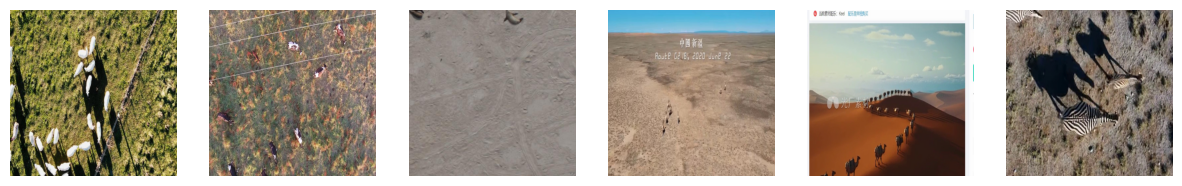

In [19]:
# let's pick a few random images and see how they look
%matplotlib inline
local_dataset = ObjectDetectionDataset(data_dir, DatasetMode.TEST, transform=None)

images = {}

for image, label, bbox in local_dataset:
    if label[0] not in images:
        images[label[0]] = (image, label, bbox)

fig, axes = plt.subplots(1, 6, figsize=(15, 5))
axes = axes.ravel()

for i, (image, label, bbox) in images.items():
    print(label)
    axes[int(i)].imshow(image)
    axes[int(i)].axis('off')

# use matplotlib to show the images
plt.show()